<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_final/Exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estrutura

1. Importação de bibliotecas e definição de funções
2. Importação dos dados

# Importação das bibliotecas e definição das funções

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import math

Utilizaremos poucas bibliotecas específicas nessa etapa, como os tradicionais numpy e pandas para manipulação de tabelas, seaborn e matplotlib com um extensão para gráficos de barras e a biblioteca math para algumas operações matemáticas.

## Definição das funções

In [2]:
# Função que remove pacientes internados na UTI nas duas primeiras horas
def remove_pts(data):
  remove = data.query("WINDOW == '0-2' and ICU == 1")["PATIENT_VISIT_IDENTIFIER"].values
  out = data.query("PATIENT_VISIT_IDENTIFIER not in @remove")
  return(out)

In [3]:
# Função que preenche as tabelas com backfill e forwardfilll quando necessário, utilizando apenas dados dos pacientes antes de irem para UTI
def fill_table(data):
    def fill_rows(rows):
        rows.loc[rows["ICU"] != 1] = rows.loc[rows["ICU"] != 1].fillna(method='bfill').fillna(method='ffill')
        # garante que só vai preencher as linhas em que o paciente ainda não foi pra UTI
        return rows
    
    cont_columns = data.iloc[:, 13:-2].columns # identificando o numero correto das colunas com dados que iremos preencher
    cont_features = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(cont_columns) + ["ICU"]].apply(fill_rows)
    cont_features.drop("ICU", axis=1, inplace=True)
    
    cat_features = data.iloc[:, :13]
    out = data.iloc[:, -2:]
    
    final_data = pd.concat([cat_features, cont_features, out], ignore_index=True, axis=1)
    final_data.columns = data.columns
    
    return final_data

In [4]:
# Função que identifica quais pacientes foram para UTI e simplifica o output colocando-os em primeiro
def id_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [5]:
# Função que plota gráficos de análise de variáveis categóricas
def categorical_plot(data, x, xtitle, figsize = (8, 6), rotation = None):

  plt.figure(figsize = figsize)
  plt.title("Análise categórica", fontsize = 20)
  sns.barplot(data = data, x = x, y = data.index,
              estimator = len, ci = None, hue = "ICU",
              order = data.loc[:, x].sort_values().unique(),
              edgecolor = "black")
  plt.tick_params(axis = "both", which = "major", labelsize = 18)
  plt.ylabel("Contagem", fontsize = 16)
  plt.xticks(rotation = rotation)
  plt.xlabel(xtitle, fontsize = 18)
  plt.legend(fontsize = "x-large", labels = ["Não foi para UTI", "Foi para UTI"])
  plt.show()

In [6]:
# Modificação da função anterior para o caso específico das variáveis de DISEASE GROUPING
def plot_disease_group(data, xtitle, figsize = (8, 6)):

  plt.figure(figsize = figsize)
  plt.title("Análise categórica", fontsize = 20)
  bar1 = sns.barplot(data = data.iloc[:, 4:10].melt(),
            x = "variable", y = "value", 
            ci = None, color = "darkgreen", edgecolor = "black", estimator = sum)
  bar2 = sns.barplot(data = data.query("ICU == 1").iloc[:,4:10].melt(),
            x = "variable", y = "value", 
            ci = None, color = "darkorange", edgecolor = "black", estimator = sum)
  plt.tick_params(axis = "both", which = "major", labelsize = 15)
  plt.xticks([0, 1, 2, 3, 4, 5], ["DG1", "DG2", "DG3", "DG4", "DG5", "DG6"])
  plt.xlabel(xtitle, fontsize = 18)
  plt.ylabel("Contagem", fontsize = 16)
  b1 = mpatches.Patch(color = "darkgreen", label = "TOTAL")
  b2 = mpatches.Patch(color = "darkorange", label = "Internações em UTI")
  plt.legend(handles = [b1, b2], loc = "upper left", fontsize = "x-large")
  plt.show()

In [7]:
# Função que plota a matriz de correlação como mapa de calor
def corr_plot(m_corr, figsize = (18,12), title = None):
  plt.figure(figsize = figsize)
  plt.title(title, fontsize = 18)
  cmap = sns.diverging_palette(250, 15, s = 75, l = 40,
                               n = 20, center = "light", as_cmap = True)
  mask = np.triu(np.ones_like(m_corr, dtype = bool))
  out = sns.heatmap(m_corr, mask = mask, center = 0,
              fmt = ".2f", square = True, cmap = cmap)
  plt.show()

In [8]:
# Função que examina a quantidade de dados faltantes:
def missing(df):
  print(df.isnull().sum())
  print()
  print(f"Total de células faltantes = {df.isnull().sum().sum()}")
  print()
  print(f"Porcentagem de dados faltantes = {round((df.isnull().sum().sum())/(df.shape[0] * df.shape[1]),2) * 100}%")

# Importação dos dados

In [9]:
df_kg = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

## df_kg == dataframe do kaggle, desafio https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

In [10]:
df_kg.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [11]:
df_kg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


Após a primeira inspeção visual do dataframe, notamos que:

1. Há diversos tipos de dados como floats (números decimais), ints (números inteiros) e objects (objetos de outros tipos). 
2. Há certos tipos de dados que parecem ser do tipo discreto e que não mudam conforme o paicente, e dados contínuos, que diferem entre as diferentes leituras de sinais vitais. 
3. Há uma quantidade de dados faltantes nas features contínuas. Podemos nos perguntar se também há dados faltantes nas features discretas:

In [12]:
df_kg.iloc[:,0:13].isnull().any() 

PATIENT_VISIT_IDENTIFIER    False
AGE_ABOVE65                 False
AGE_PERCENTIL               False
GENDER                      False
DISEASE GROUPING 1           True
DISEASE GROUPING 2           True
DISEASE GROUPING 3           True
DISEASE GROUPING 4           True
DISEASE GROUPING 5           True
DISEASE GROUPING 6           True
HTN                          True
IMMUNOCOMPROMISED            True
OTHER                        True
dtype: bool

Há também dados faltantes nas features discretas. Por último, podemos nos perguntar qual a quantidade total de dados faltantes:

In [13]:
missing(df_kg)

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64

Total de células faltantes = 223863

Porcentagem de dados faltantes = 50.0%


Podemos ver que pelo menos **metade** do nosso dataset não há informação. Um primeiro caminho poderia ser remover todos esses dados. Isso não é o ideal, já que, de acordo com as recomendações da própria equipe do Sírio Libanês, há algumas etapas que podemos seguir para minimizar a nossa perda de informação.

# Limpeza dos dados

Antes de mais nada, o primeiro passo deve ser remover de prontidão todos os pacientes que deram entrada na UTI na primeira janela de tempo. Essa medida é baseada na recomendação da equipe de utilizar comentes os dados disponíveis até o momento da internação. Para isso, aplico a função ```remove_pts```:

In [14]:
df_fill1 = remove_pts(df_kg)

Depois, aplicaremos a função ```fill_table```, o cerne dessa preparação de dados. Essa função irá preencher os dados faltantes utilizando-se das medições anteriores ou posteriores à janela de tempo em questão, baseando-se no princípio de que os sinais vitais não variam ou pouco variam nesses curtos intervalos de tempo. A função irá:

1. Identificar primeiro as linhas vazias de cada paciente anterior ao momento da internação, pois não utilizará os dados obtidos somente após a internação.
2. Preencher o dado faltante primeiro com a medição do intervalo **posterior (backfill)**, desde que o paciente ainda não tenha dado entrada na UTI e, quando necessário, preencher com a medição do intervalo **anterior (forwardfill)**.

Essa diferenciação se faz necessária porque a princípio não temos informação sobre o momento exato das medidas aferidas na janela de internação da UTI: elas podem ter sido tomadas logo antes ou logo após a admissão na UTI.

In [15]:
df_fill2 = fill_table(df_fill1)

Agora, vamos examinar se ainda há dados faltantes:

In [16]:
missing(df_fill2)

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     119
TEMPERATURE_DIFF_REL          101
OXYGEN_SATURATION_DIFF_REL     99
WINDOW                          0
ICU                             0
Length: 231, dtype: int64

Total de células faltantes = 36459

Porcentagem de dados faltantes = 9.0%


Podemos notar que já houve uma queda considerável da quantidade de dados faltantes, mas ainda há uma quantidade não negligenciável. Por que isso ocorre? Podemos aplicar alguns procedimentos para identificar **onde estão e quais são** esses dados faltantes:

In [17]:
np.where(df_fill2.isnull()) # onde estão?

(array([  53,   53,   53, ..., 1728, 1728, 1728]),
 array([ 13,  14,  15, ..., 190, 191, 192]))

In [18]:
df_fill2.iloc[50:55,] # quais são?

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
55,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
56,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
57,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
58,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.456790,-0.338462,-0.396226,-0.050847,0.178571,0.736842,-0.456790,-0.338462,-0.396226,-0.034483,0.178571,0.736842,-0.216495,-0.0875,-0.264957,0.071429,0.494505,0.898990,-0.623932,-0.535135,-0.522388,-0.151515,-0.043478,0.736842,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
59,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

Valores faltantes aparecem na seguinte situação: se um paciente tem uma lacuna de medição exatamente na janela anterior à internação e possui dados após a internação, estes valores não serão utilizados para preencher a lacuna anterior.

O que podemos fazer agora é aplicar uma nova função que determinará o seguinte: seguindo as recomendações no Kaggle, o que precisamos é resumir os dados utilizando somente a informação se o paciente deu entrada ou não na UTI, e utilizar os dados somente da primeira janela. É uma simplificação dos dados que parte do mesmo princípio de que se espera que não haja muita variação entre as medições de sinais vitais. Temos ciência de que pode não ser o cenário ideal para um modelo mais complexo e potencialmente mais informativo, mas essa simplificação torna o processo bastante eficiente: precisamos detectar rapidamente a possibilidade de um paciente ser admitido na UTI.

É necessário fazer essa etapa somente depois de preencher dados faltantes, pois muitos pacientes podem ter medidas faltantes em janelas iniciais, mas ainda assim terem medidas em momentos anteriores à internação. Se fizeremos o resumo dos dados antes, essas medidas seriam completamente perdidas e potencialmente alguns pacientes ficariam de fora do modelo final.

In [19]:
df_fill3 = df_fill2.groupby("PATIENT_VISIT_IDENTIFIER").apply(id_window)
df_fill3.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

Lembrando então agora que temos um dataset resumido, com apenas uma linha por paciente.
E então, como isso mudou a situação com relação aos dados faltantes?

In [20]:
missing(df_fill3)

PATIENT_VISIT_IDENTIFIER       0
AGE_ABOVE65                    0
AGE_PERCENTIL                  0
GENDER                         0
DISEASE GROUPING 1             1
                              ..
RESPIRATORY_RATE_DIFF_REL     46
TEMPERATURE_DIFF_REL          39
OXYGEN_SATURATION_DIFF_REL    36
WINDOW                         0
ICU                            0
Length: 231, dtype: int64

Total de células faltantes = 4635

Porcentagem de dados faltantes = 6.0%


In [21]:
np.where(df_fill3.isnull()) # onde estão?

(array([ 16,  16,  16, ..., 341, 341, 341]),
 array([193, 194, 195, ..., 226, 227, 228]))

In [22]:
df_fill3.iloc[16:20,:] # quais são?

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,1
19,95,19,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.923600,-0.923600,...,-0.998073,-1.0,-0.234568,0.123077,-0.811321,-0.186441,-0.107143,0.842105,-0.234568,0.123077,-0.811321,-0.172414,-0.107143,0.842105,-0.030928,0.2875,-0.641026,-0.071429,0.318681,0.939394,-0.470085,-0.210811,-0.850746,-0.272727,-0.275362,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
20,100,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.965463,-0.965463,...,-0.994912,-1.0,-0.037037,-0.553846,-0.547170,-0.593220,-0.250000,0.842105,-0.037037,-0.553846,-0.547170,-0.586207,-0.250000,0.842105,0.134021,-0.2625,-0.401709,-0.500000,0.230769,0.939394,-0.333333,-0.686486,-0.641791,-0.636364,-0.391304,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
21,105,21,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.769634,-0.769634,-0.769634,-0.769634,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,-1.0,-0.764521,-0.764521,...,-0.978029,-1.0,-0.358025,-0.800000,-0.320755,-0.525424,0.357143,0.684211,-0.358025,-0.800000,-0.320755,-0.517241,0.357143,0.684211,-0.134021,-0.4625,-0.196581,-0.428571,0.604396,0.878788,-0.555556,-0.859459,-0.462687,-0.575758,0.101449,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0


Mesmo após esse processo, o paciente 18 continua aparecendo com dados faltantes, e foi admitido na UTI. Vamos retornar ao dataset original para verificar como eram os dados desse paciente:

In [23]:
df_kg.query("PATIENT_VISIT_IDENTIFIER == '18'")

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
91,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
92,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.399177,-0.133333,-0.295597,-0.186441,0.178571,0.807018,0.382716,-0.076923,-0.415094,-0.034483,0.178571,0.842105,0.484536,-0.0125,-0.282051,-0.357143,0.494505,0.898990,-0.008547,-0.351351,-0.253731,-0.151515,-0.043478,0.842105,-0.965217,-0.865031,-0.709924,-0.647059,-1.000000,-0.959596,-0.977316,-0.876606,-0.766327,-0.736774,-1.000000,-0.960463,4-6,1
93,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.046154,-0.358491,-0.118644,0.142857,0.894737,0.333333,-0.046154,-0.358491,-0.103448,0.142857,0.894737,0.443299,0.1500,-0.230769,0.000000,0.472527,0.959596,-0.076923,-0.329730,-0.492537,-0.212121,-0.072464,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
94,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.990518,-1.0,0.220576,-0.234359,-0.100629,-0.335593,-0.055952,0.726316,0.209877,-0.276923,-0.113208,-0.448276,-0.071429,0.710526,-0.072165,-0.1625,-0.213675,-0.714286,0.054945,0.858586,0.128205,-0.189189,0.074627,0.333333,0.130435,0.789474,-0.356522,-0.533742,-0.435115,0.117647,-0.380952,-0.939394,-0.545780,-0.530096,-0.627689,0.096774,-0.379238,-0.939126,ABOVE_12,1


O paciente 18 só teve suas medições aferidas após a internação na UTI. Nesse caso, nada pode ser feito, a não ser remover esse tipo de dado. Como já estamos trabalhando com um dataset resumido, o último passo é retirar todas as linhas com dados faltantes:

In [24]:
df_fill4 = df_fill3.dropna()

In [25]:
df_fill4.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

In [26]:
missing(df_fill4)

PATIENT_VISIT_IDENTIFIER      0
AGE_ABOVE65                   0
AGE_PERCENTIL                 0
GENDER                        0
DISEASE GROUPING 1            0
                             ..
RESPIRATORY_RATE_DIFF_REL     0
TEMPERATURE_DIFF_REL          0
OXYGEN_SATURATION_DIFF_REL    0
WINDOW                        0
ICU                           0
Length: 231, dtype: int64

Total de células faltantes = 0

Porcentagem de dados faltantes = 0.0%


Agora sim, não temos mais nenhum dado faltante. Vamos examinar o tamanho do dataset final em comparação ao inicial:

In [27]:
print(f"Data frame original = {df_kg.shape}")
print(f"Após limpeza = {df_fill4.shape}")

Data frame original = (1925, 231)
Após limpeza = (294, 231)


# Análise exploratória

Como observamos anteriormente, o dataframe consiste de dados categóricos, como idade, gênero, doenças pré-existentes, e dados contínuos como oxigenação relativa, temperatura relativa, pressão diastólica, níveis de albumina, etc.

Como a quantidade de variáveis categóricas é relativamente pequena comparada à quantidade de variáveis contínuas, podemos observar a distribuição destes dados no nosso conjunto final, e também, observar se há uma relação entre as classes e a chance do paciente ser admitido na UTI.

## Variáveis categóricas

In [28]:
df_final = df_fill4.reset_index(drop = True)

In [29]:
df_final.head() # relembrando o dataframe final

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,0

Primeiro, qual o número absoluto de pessoas que foram ou não internadas na UTI:

In [30]:
df_final.loc[:,"ICU"].value_counts()

0    189
1    105
Name: ICU, dtype: int64

Em dados categóricos, 0 geralmente indica a condição negativa (no nosso caso, não foram internadas na UTI), e 1 a condição positiva (foram internadas). Mas também pode representar outras classes, como veremos adiante.

Temos então que 189 pessoas não foram para UTI e 105 sim, mostrando um resultado relativamente desbalanceado, quase o dobro de pessoas tem a categoria 0.

### Categorias de idade:

Muito se discute se a probabilidade de um paciente ser internado ou não na UTI está associada com a sua idade, seja em valores absolutos, ou se o fato do paciente ser idoso ou não é determinante dessa possibilidade. A primeira variável que carrega essa informação no dataset é a coluna ```AGE_ABOVE65```, que identifica se o paciente tem mais ou menos de 65 anos:

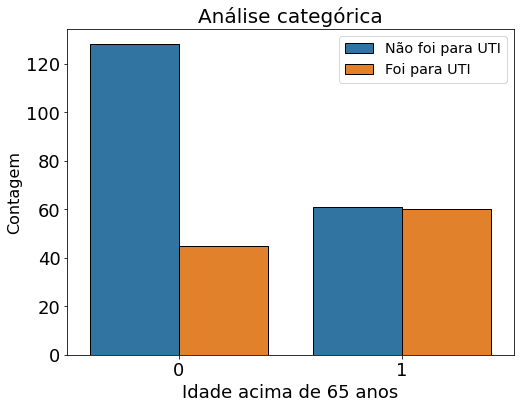

In [31]:
categorical_plot(data = df_final, x = "AGE_ABOVE65", xtitle = "Idade acima de 65 anos")

Legenda: gráfico de barras da distribuição de internações na UTI conforme idade maior ou menor que 65 anos. 0 para menor, 1 para maior.

Podemos observar que mesmo não havendo um aumento no número **absoluto** de internações em pessoas com mais de 65 anos em relação às internações com menos de 65 anos, há um aumento considerável **proporcionalmente**. Há uma proporção de 1/3 dos pacientes precisando de internação entre < 65, e uma proporção de 1/2 entre os > 65.

Porém, há um outro dado relativo a idade que é a idade absoluta:

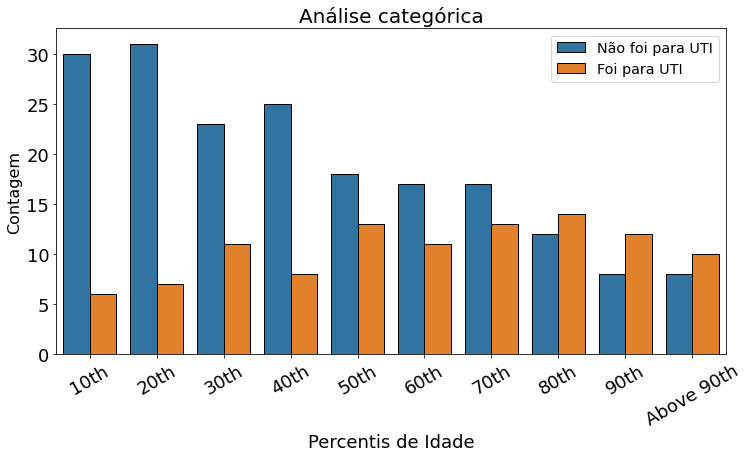

In [32]:
categorical_plot(data = df_final, x = "AGE_PERCENTIL", xtitle = "Percentis de Idade", rotation = 30, figsize = (12, 6))

Legenda: gráfico de barras da distribuição de internações na UTI conforme percentis de faixa etária. 10th indica pacientes de até 10 anos, e assim sucessivamente.

Podemos perceber que conforme maior a idade, sobretudo nos idosos acima de 70 anos, um maior número de pessoas é internada na UTI em relação às pessoas que não são internadas.

### Gênero:

E dados sobre gênero?

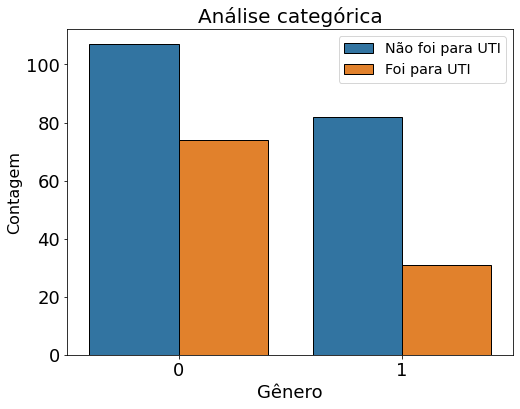

In [33]:
categorical_plot(data = df_final, x = "GENDER", xtitle = "Gênero")

Legenda: gráfico de barras da distribuição de internações na UTI conforme gênero. 0 = masculino, 1 = feminino.

Podemos ver que, proporcionalmente mais homens foram internados na UTI do que mulheres.

### Doenças pré-existentes:

Um outro tipo de dado disponível do dataframe é uma combinação de 6 grupos de doenças pré-existentes em cada paciente. Devido os protocolos de anonimização, não sabemos quais são esses tipos de doenças, mas podemos examinar sua distribuição também:

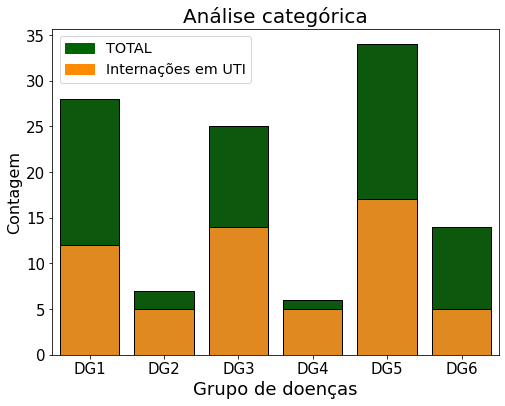

In [34]:
plot_disease_group(df_final, xtitle = "Grupo de doenças")

Legenda: gráficos de barras empilhadas para indicar a distribuição dos grupos de doenças. Atente-se ao fato de que a visualização é um pouco diferente, devido à diferença na natureza dessa variável no dataframe: ele indica a proporção de internações em relação ao total na mesma barra.

Vemos que os grupos de doenças 2 e 4 apresentam um alto risco de internação em UTI, quando comparados aos outros grupos que tem uma distribuição mais proporcional.

A próxima variável relativa à doenças é se o paciente apresenta ou não hipertensão:


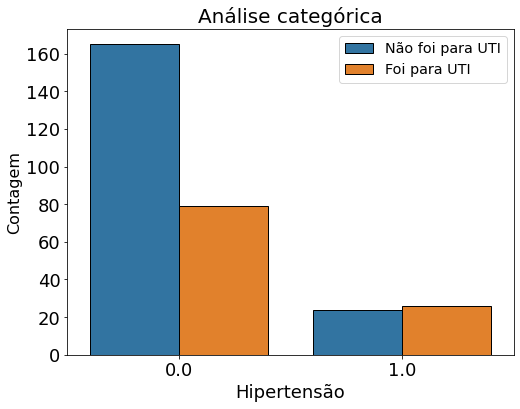

In [35]:
categorical_plot(data = df_final, x = "HTN", xtitle = "Hipertensão")

Legenda: gráfico de barras da distribuição de internações na UTI conforme hipertensão. 0 = não apresenta, 1 = apresenta.

Aparentemente a hipertensão também está associada com risco de internação na UTI.

[Imunodeficiência](https://en.wikipedia.org/wiki/Immunodeficiency) é um tipo de condição clínica em que a habilidade do sistema imune de uma pessoa combater infecções está comprometida ou é completamente ausente.

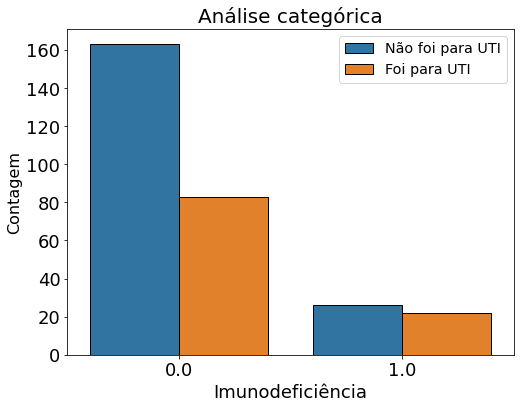

In [36]:
categorical_plot(data = df_final, x = "IMMUNOCOMPROMISED", xtitle = "Imunodeficiência")

Legenda: gráfico de barras da distribuição de internações na UTI conforme imunodeficiência. 0 = não apresenta, 1 = apresenta.

Embora o número total de pessoas que apresente imunodeficiência seja relativamente baixo, proporcionalmente mais pessoas com imunodeficiência foram internadas na UTI quando comparadas às pessoas sem imunodeficiência. De forma parecida com o ocorrido para hipertensão.

Uma última categoria abordada no dataframe, para a qual não temos nenhuma informação de sua natureza, chama-se simplesmente "OTHER (outro)". Podemos observá-la:

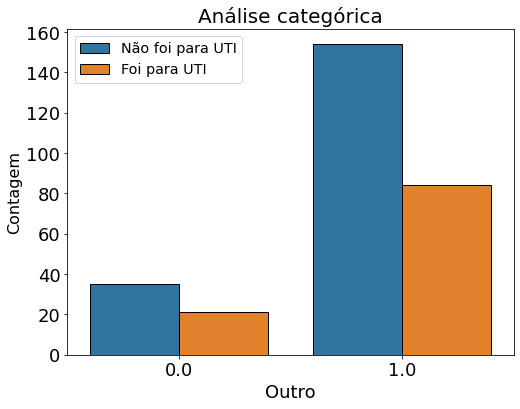

In [37]:
categorical_plot(df_final, x = "OTHER", xtitle = "Outro")

Legenda: gráfico de barras da distribuição de internações na UTI conforme categoria "OTHER". 0 = não apresenta, 1 = apresenta.

Aparentemente, é uma característica frequente na população, dado que a maior parte a apresenta, mas não parece haver relação com a probabilidade de internação em UTI.



---



Por último, mas não menos importante, uma transformação necessária para melhor ajustar os dados de idade da coluna AGE PERCENTIL para a forma como serão trabalhados nos modelo de machine learning será utilizar o [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). Esse método converte categorias discretas interpretadas como ordinais em puramente categóricas binárias, no mesmo formato de 0s e 1s utilizado nas outras variáveis categóricas. Eu não realizei esse passo anteriormente a fim de facilitar a visualização das categorias em uma única coluna. Vamos realizar essa etapa agora:

In [38]:
df_final = pd.get_dummies(df_final, columns = ["AGE_PERCENTIL"])
df_final.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1,1,0,0,0,0,0,0,0,0,0
2,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0,1,0,0,0,0,0,0,0,0,0
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.537736,-0.517241,-0.196429,0.8

# Análise exploratóra de variáveis contínuas

Primeiro, sabemos que o número de variáveis contínuas é muito maior 

In [ ]:
with pd.option_context('display.max_seq_items', None):
   print (df_final.columns)

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN',
       'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN',
       'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX',
       'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN',
       'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN',
       'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX',
       'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN',
       'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN',
       'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_MEAN', 'CAL

Uma primeira abordagem é examinar o comportamento de um subgrupo de dados, por exemplo a mediana:

In [ ]:
df_median = df_final.filter(regex = "_MEDIAN", axis = 1)

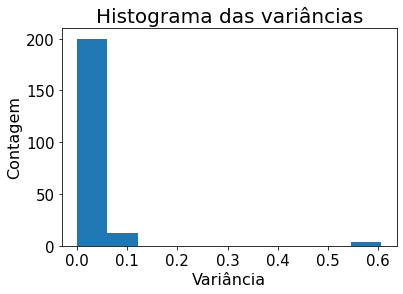

In [ ]:
plt.hist(list(df_final.iloc[:,12:228].var()))
plt.title("Histograma das variâncias", fontsize = 20)
plt.xlabel("Variância", fontsize = 16)
plt.ylabel("Contagem", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

Resumidamente, temos muitos dados com distribuições muito parecidas e muito próximas. Isso pode levar a uma grande taxa de falsos positivos devido às altas correlações entre as variáveis. A próxima etapa então é analisar diretamente estas correlações:

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 240 entries, PATIENT_VISIT_IDENTIFIER to AGE_PERCENTIL_Above 90th
dtypes: float64(225), int64(4), object(1), uint8(10)
memory usage: 531.3+ KB


É improdutivo tentar qualquer visualização de correlação de tantas colunas assim. Podemos tentar com aquele objeto das médias de novo:

In [ ]:
m_corr_medians = df_median.corr().abs()

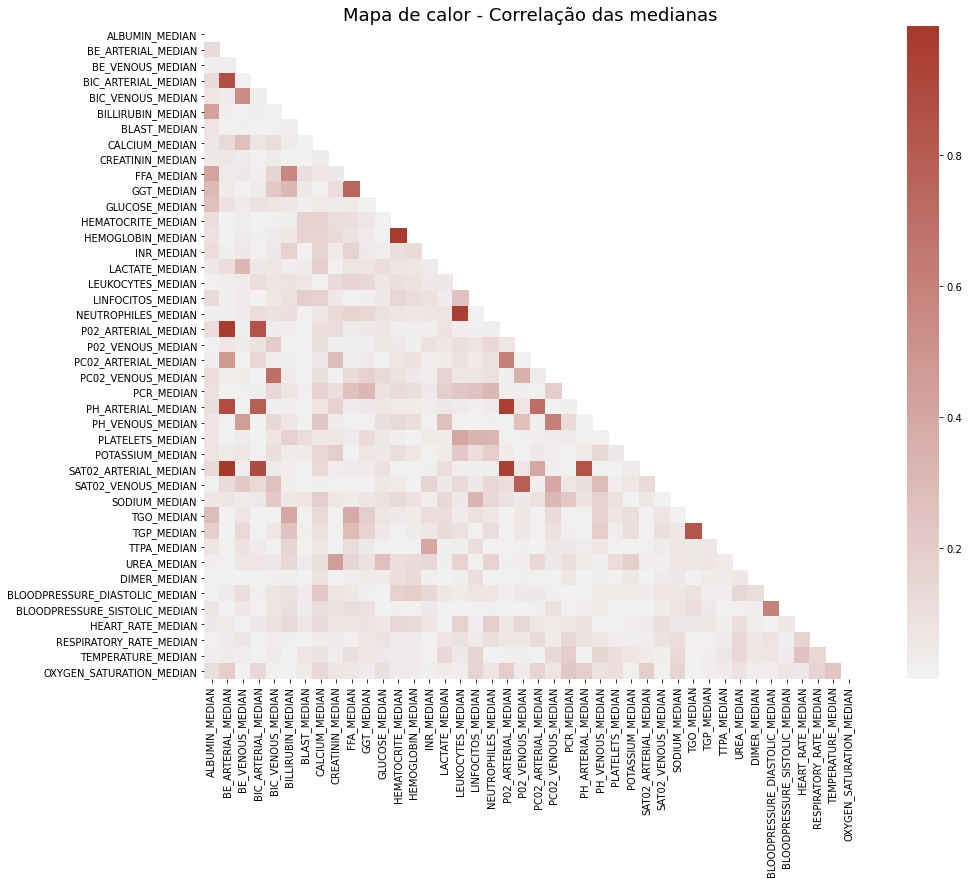

In [ ]:
corr_plot(m_corr = m_corr_medians, title = "Mapa de calor - Correlação das medianas")

As medianas não apresentam altas correlações, indicando que as medidas são de fato diferentes entre si. Vamos expandir esse raciocínio para o conjunto de todas as features contínuas.

In [ ]:
cont_features = df_final.iloc[:,12:228]

In [ ]:
cat_features = df_final.iloc[:,np.r_[0:12, 230:239]]
out = df_final.loc[:,["WINDOW", "ICU"]]

In [ ]:
m_corr = cont_features.corr().abs()
m_corr

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625

Por que alguns valores retornam NaN?

In [ ]:
cont_features.describe()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
count,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.0,...,294.000000,294.000000,294.000000,294.0,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.583333,0.583333,0.583333,0.583333,-1.0,-0.999127,-0.999127,-0.999127,-0.999127,-1.0,-0.966770,-0.966770,-0.966770,-0.966770,-1.0,-0.316907,-0.316907,-0.316907,-0.316907,-1.0,-0.320226,-0.320226,-0.320226,-0.320226,-1.0,-0.943813,-0.943813,-0.943813,-0.943813,-1.0,-0.992311,-0.992311,-0.992311,-0.992311,-1.0,0.329307,0.329307,0.329307,0.329307,-1.0,...,-0.960041,-0.960041,-0.960041,-1.0,-0.027803,-0.339129,-0.236224,-0.494315,0.114374,0.759233,-0.027211,-0.339770,-0.234180,-0.484635,0.112609,0.760741,0.118732,-0.103614,-0.137508,-0.412779,0.441878,0.899540,-0.310192,-0.521934,-0.381562,-0.532055,-0.075027,0.776763,-0.963561,-0.969200,-0.969777,-0.970588,-0.968902,-0.985226,-0.968574,-0.967168,-0.979110,-0.971495,-0.969322,-0.985233
std,0.121646,0.121646,0.121646,0.121646,0.0,0.012714,0.012714,0.012714,0.012714,0.0,0.098833,0.098833,0.098833,0.098833,0.0,0.006370,0.006370,0.006370,0.006370,0.0,0.081793,0.081793,0.081793,0.081793,0.0,0.047196,0.047196,0.047196,0.047196,0.0,0.117576,0.117576,0.117576,0.117576,0.0,0.080885,0.080885,0.080885,0.080885,0.0,...,0.104404,0.104404,0.104404,0.0,0.247065,0.257476,0.266177,0.190216,0.270283,0.119243,0.252430,0.258757,0.274602,0.198540,0.274601,0.125995,0.218061,0.213496,0.240673,0.199892,0.167164,0.049846,0.171095,0.183944,0.216553,0.181270,0.229508,0.122137,0.089336,0.080849,0.094492,0.090889,0.085524,0.033585,0.086117,0.087508,0.056166,0.079718,0.083745,0.034103
min,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.365854,-0.365854,-0.365854,-0.365854,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.994767,-0.994767

Os valores de "DIFF" parecem não ter nenhuma variação:

In [ ]:
np.where(cont_features.describe().loc["std"] == 0)

(array([  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,
         69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129,
        134, 139, 144, 149, 154, 159, 164, 169, 174, 179]),)

Podemos removê-los:

In [ ]:
remove_zero_std = cont_features.columns[np.where(cont_features.describe().loc["std"] == 0)]
remove_zero_std

Index(['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF',
       'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF',
       'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF',
       'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF',
       'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF',
       'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF',
       'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF',
       'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF',
       'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF',
       'DIMER_DIFF'],
      dtype='object')

In [ ]:
cont_features = cont_features.drop(remove_zero_std, axis = 1)

Mas será que foram TODOS os valores de DIFF embora?

In [ ]:
cont_features.filter(regex = "_DIFF", axis = 1).columns

Index(['BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF',
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object')

Não, podemos continuar:

In [ ]:
m_corr = cont_features.corr().abs()
m_corr

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,1.000000,1.000000,1.000000,1.000000,0.124220,0.124220,0.124220,0.124220,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.0515

In [ ]:
m_corr_sup = m_corr.where(np.triu(np.ones(m_corr.shape).astype(np.bool), k = 1))
m_corr_sup # matriz superior

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,NaN,1.0,1.0,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,NaN,NaN,1.0,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,NaN,NaN,NaN,1.0,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,NaN,NaN,NaN,NaN,0.12422,0.12422,0.12422,0.12422,0.021082,0.021082,0.021082,0.021082,0.119674,0.119674,0.119674,0.119674,0.059078,0.059078,0.059078,0.059078,0.429199,0.429199,0.429199,0.429199,0.074625,0.074625,0.074625,0.074625,0.058743,0.058743,0.058743,0.058743,0.051568,0.051568,0.051568,0.051568,0.415273,0.415273,0.415273,0.415273,...,0.014923,0.014923,0.014923,0.014923,0.005309,0.075161

O que parece acontecer agora é que as correlações parecem ser muito fortes entre as diferentes estatísticas de uma mesma medida, média, mediana, min e max são muito correlacionadas. Suspeito que perfeitamente correlacionadas. Uma forma de examinar será justamente identificar esses casos:

In [ ]:
one_corr_columns = [column for column in m_corr_sup.columns if any(m_corr_sup[column] == 1)]
len(one_corr_columns)

108

Isso indica que, ao menos 108 colunas possuem algum valor de correlação == 1, ou seja, são perfeitamente correlacionadas. Se nós olharmos quais são essas colunas:

In [ ]:
one_corr_columns

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEAN',
 'NEUTROPHILES_MIN',
 'NEUTROPHILES_MAX',


Como as colunas de mediana vem primeiro no dataset, elas são mantidas ao se comparar com as próximas medidas.

De forma complementar, podemos ver quais colunas **ficariam** ao remover as colunas acima:

In [ ]:
cont_features.drop(one_corr_columns, axis = 1).columns

Index(['ALBUMIN_MEDIAN', 'BE_ARTERIAL_MEDIAN', 'BE_VENOUS_MEDIAN',
       'BIC_ARTERIAL_MEDIAN', 'BIC_VENOUS_MEDIAN', 'BILLIRUBIN_MEDIAN',
       'BLAST_MEDIAN', 'CALCIUM_MEDIAN', 'CREATININ_MEDIAN', 'FFA_MEDIAN',
       'GGT_MEDIAN', 'GLUCOSE_MEDIAN', 'HEMATOCRITE_MEDIAN',
       'HEMOGLOBIN_MEDIAN', 'INR_MEDIAN', 'LACTATE_MEDIAN',
       'LEUKOCYTES_MEDIAN', 'LINFOCITOS_MEDIAN', 'NEUTROPHILES_MEDIAN',
       'P02_ARTERIAL_MEDIAN', 'P02_VENOUS_MEDIAN', 'PC02_ARTERIAL_MEDIAN',
       'PC02_VENOUS_MEDIAN', 'PCR_MEDIAN', 'PH_ARTERIAL_MEDIAN',
       'PH_VENOUS_MEDIAN', 'PLATELETS_MEDIAN', 'POTASSIUM_MEDIAN',
       'SAT02_ARTERIAL_MEDIAN', 'SAT02_VENOUS_MEDIAN', 'SODIUM_MEDIAN',
       'TGO_MEDIAN', 'TGP_MEDIAN', 'TTPA_MEDIAN', 'UREA_MEDIAN',
       'DIMER_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'BLOODPRESSURE_SISTOLIC_MEAN', 'HEART_RATE_MEAN',
       'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'OXYGEN_SATURATION_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_SIS

Ou seja, há uma série de medidas bastante redundantes entre média, mediana, mínimo e máximo; mas também uma série de medidas em que os valores não são idênticos. Podemos identificar também que essas medidas não redudantes podem ser de um grupo distinto, pois vem depois das medidas redundantes e elas não tem a mesma estrutura, podendo indicar que são foram obtidas de forma diferente, em exames diferentes talvez.

O que fazer? Pode ser interessante então aplicar a remoção de colunas com um valor de threshold de alta correlação, pois vamos remover as colunas idênticas seriadas do começo do dataset e manter algumas colunas da segunda série de medidas, que vimos não serem idênticas, mas podem ainda ser altamente correlacionadas:

In [ ]:
def corr_test(m_corr, corr_val):
  print(len([column for column in m_corr.columns if any(m_corr[column] > corr_val)]))

In [ ]:
corrs_to_test = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for k in range(1,6):
  corr_test(m_corr_sup, corrs_to_test[k])

146
141
139
137
134


Ou seja, faz relativamente pouca diferença conforme nos afastamos de um valor muito alto de correlação de 0.95.

In [ ]:
high_corr_columns = [column for column in m_corr_sup.columns if any(m_corr_sup[column] > 0.95)]
cont_features = cont_features.drop(high_corr_columns, axis = 1)

In [ ]:
final_corr = cont_features.corr().abs()

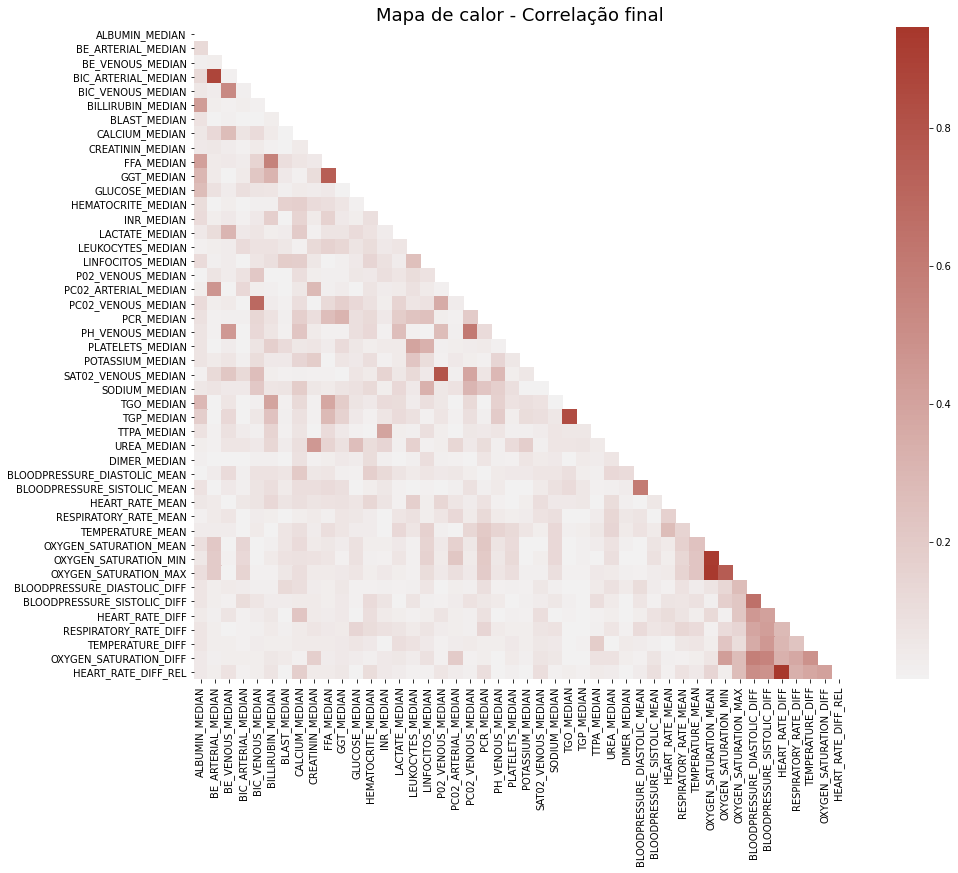

In [ ]:
corr_plot(m_corr = final_corr, title = "Mapa de calor - Correlação final")

Agora temos um bom resultado, com uma quantidade razoável de colunas com baixa correlação entre elas.

In [ ]:
df_clean = pd.concat([cat_features, cont_features, out], axis = 1)

In [ ]:
df_clean

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MIN,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.704142,-0.77931,-0.754601,-0.875236,0.363636,-0.540721,-0.518519,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.898990,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.704142,-0.77931,-0.754601,-0.939887,0.363636,-0.399199,-0.703704,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,0.959596,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
2,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.633136,-0.77931,-0.779141,-0.503592,0.363636,-0.564753,-0.777778,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.878788,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.704142,-0.77931,-0.754601,-0.990926,0.363636,-0.457944,-0.592593,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.939394,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.704142,-0.77931,-0.754601,-0.997732,0.363636,-0.292390,-0.666667,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,0.919192,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2

In [ ]:
df_final.to_csv("data_pre_processing.csv", index = False)

df_clean.to_csv("data_clean.csv", index = False)

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

https://en.wikipedia.org/wiki/Immunodeficiency